# Compare different mean estimators to bulk data

Bulk data here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE164457

In [69]:
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [13]:
data_path = '/data_volume/memento/method_comparison/lupus/'

### Read single cell and bulk data

In [14]:
adata = sc.read(data_path + '../../lupus/Lupus_study_adjusted_counts.h5ad')

In [50]:
bulk = pd.read_csv(data_path + 'lupus_bulk.csv', index_col=0)

In [16]:
def get_sc_ind(x):
    
    if '-' in x:
        return x.split('-')[1]
    elif '_' in x:
        return x.split('_')[0]
    else:
        return x

In [17]:
meta = adata.obs[['ind_cov', 'Age', 'Sex', 'SLE_status']].drop_duplicates().reset_index(drop=True)
meta['ind'] = meta['ind_cov'].apply(get_sc_ind)

In [18]:
sc_inds = set(meta['ind'].tolist())

In [19]:
bulk_inds = set(bulk.columns.str.split('_').str[1].tolist())

In [20]:
inds = list(sc_inds & bulk_inds)

In [21]:
meta = meta[meta['ind'].isin(inds)]

In [22]:
genes = list(set(bulk.index) & set(adata.var.index))

### Different estimators

In [27]:
adata.obs['ind'] = adata.obs['ind_cov'].apply(get_sc_ind)

In [63]:
def pseudobulk(data):
    
    return data.sum(axis=0)/data.sum()

def sample_mean(data):
    sf = data.sum(axis=1).reshape(-1,1)
    return (data/sf).mean(axis=0)

def iv_mean(data):

    q=0.07
    augmented_data = np.append(data, np.ones((1,data.shape[1])), axis=0)
    sf = augmented_data.sum(axis=1)
    X = augmented_data/sf.reshape(-1,1)
    naive_v = X.var(axis=0)
    naive_m = X.mean(axis=0)
    v = naive_v-(1-q)*(X/(sf**2-sf*(1-q)).reshape(-1,1)).mean(axis=0)
    variance_contributions = ((1-q)/sf).reshape(-1,1)*naive_m.reshape(1,-1) + v.reshape(1,-1)
    m = np.average( X, weights=1/variance_contributions, axis=0)
    
    return m

In [26]:
ct = 'T4'

In [45]:
compare_genes = adata[(adata.obs['cg_cov']==ct), genes].X.mean(axis=0).A1
compare_genes = list(np.array(genes)[(compare_genes > 0.01)])

In [68]:
results = []
for ind in inds:
    
    sc_data = adata[(adata.obs['ind']==ind) & (adata.obs['cg_cov']==ct), compare_genes].X.toarray()
    
    pb = pseudobulk(sc_data)
    sm = sample_mean(sc_data)
    im = iv_mean(sc_data)
    ind_bulk = bulk.loc[compare_genes, 'CD4_'+ind]
    results.append((stats.spearmanr(ind_bulk, pb)[0], 'pseudobulk'))
    results.append((stats.spearmanr(ind_bulk, sm)[0], 'sample_mean'))
    results.append((stats.spearmanr(ind_bulk, im)[0], 'iv_mean'))
results = pd.DataFrame(results, columns=['corr', 'method'])

<AxesSubplot: xlabel='method', ylabel='corr'>

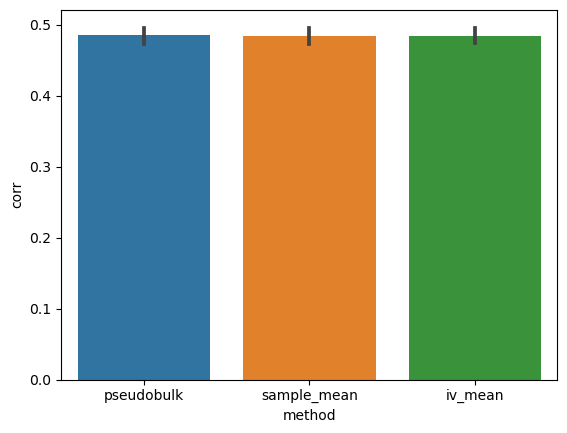

In [70]:
sns.barplot(x='method', y='corr', data=results)